In [22]:
import os, csv, re
import pandas as pd
import numpy as np

import math
from scipy.sparse import issparse
import random 
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad
#import cv2
import time

In [17]:
adata= sc.read_h5ad("/storage2/fs1/sanjayjain/Active/Xenium/Banksy_Atlas/Banksy_4_Biopsies_new.h5ad")

In [24]:
adata.obs['manual_annotations']

aaaabfmn-1    other
aaadkbin-1    other
aaaihdol-1    other
aaamkgia-1      CNT
aabalioo-1        T
              ...  
oihkokef-1    altPC
oihnnalf-1       PC
oiidakbm-1       PC
oiidbdnl-1       PL
oiiecmln-1       PC
Name: manual_annotations, Length: 469943, dtype: category
Categories (45, object): ['ATL', 'B', 'CNT', 'DC', ..., 'moMAC-INF', 'other', 'pvFIB', 'resMAC']

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='Glom'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,20))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

In [30]:
counts

,Annotation,Cluster,Count,Proportion,x,y,size,color
0,EC-GC,0,4,0.000530,0,0,0.079470,"(0.12156862745098039, 0.4666666666666667, 0.70..."
1,EC-GC,1,29,0.003841,0,1,0.576159,"(0.6823529411764706, 0.7803921568627451, 0.909..."
2,EC-GC,2,0,0.000000,0,2,0.000000,"(1.0, 0.4980392156862745, 0.054901960784313725)"
3,EC-GC,3,53,0.007020,0,3,1.052980,"(1.0, 0.7333333333333333, 0.47058823529411764)"
4,EC-GC,4,762,0.100927,0,4,15.139073,"(0.17254901960784313, 0.6274509803921569, 0.17..."
...,...,...,...,...,...,...,...,...
95,altPOD,15,5,0.002175,4,15,0.326229,"(0.7803921568627451, 0.7803921568627451, 0.780..."
96,altPOD,16,0,0.000000,4,16,0.000000,"(0.7372549019607844, 0.7411764705882353, 0.133..."
97,altPOD,17,153,0.066551,4,17,9.982601,"(0.8588235294117647, 0.8588235294117647, 0.552..."
98,altPOD,18,1,0.000435,4,18,0.065246,"(0.09019607843137255, 0.7450980392156863, 0.81..."


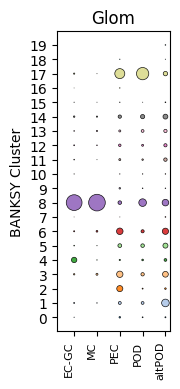

In [31]:
fig, ax = plt.subplots(figsize=(1.9, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('Glom', fontsize=12)

plt.tight_layout()
plt.savefig("glombanksy_IU.png")
plt.show()

## PT 

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='PT'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,20))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

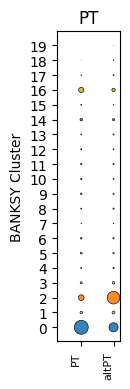

In [35]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('PT', fontsize=12)

plt.tight_layout()
plt.savefig("PTbanksy_IU.png")
plt.show()

## TAL 

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='TAL'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,20))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

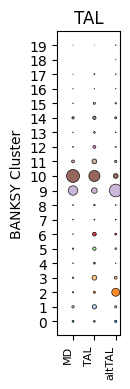

In [37]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('TAL', fontsize=12)

plt.tight_layout()
plt.savefig("TALbanksy_IU.png")
plt.show()

## Immune

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal", 
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal", "Lymphoid" : "Immune","Myeloid": "Immune",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='Immune'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,20))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

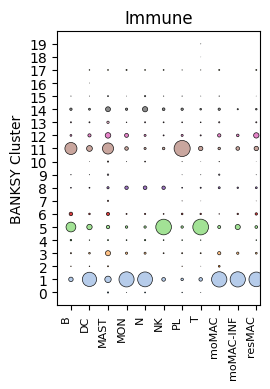

In [49]:
fig, ax = plt.subplots(figsize=(2.8, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('Immune', fontsize=12)

plt.tight_layout()
plt.savefig("Immunebanksy_IU.png")
plt.show()

## Stromal

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "aFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='Stromal'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,20))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

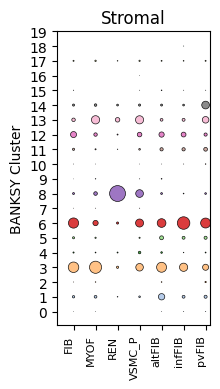

In [47]:
fig, ax = plt.subplots(figsize=(2.3, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('Stromal', fontsize=12)

plt.tight_layout()
plt.savefig("Stromalbanksy_IU.png")
plt.show()

## TL 

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "EC","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Stromal",
    "REN": "Stromal",  "VSMC/P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='TL'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,15))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

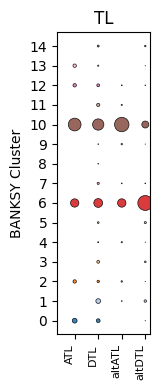

In [63]:
fig, ax = plt.subplots(figsize=(1.7, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('TL', fontsize=12)

plt.tight_layout()
plt.savefig("TLbanksy_new.png")
plt.show()

## PC 

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='PC'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,15))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

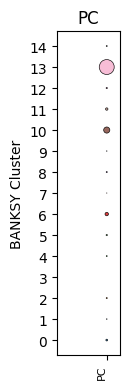

In [101]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('PC', fontsize=12)

plt.tight_layout()
plt.savefig("PCbanksy_new.png")
plt.show()

## IC 

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='IC'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,15))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

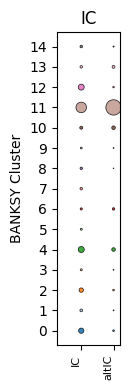

In [103]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('IC', fontsize=12)

plt.tight_layout()
plt.savefig("ICbanksy_new.png")
plt.show()

## CNT 

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='CNT'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,15))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

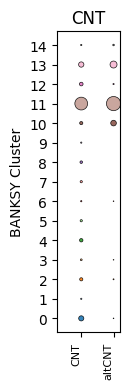

In [105]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('CNT', fontsize=12)

plt.tight_layout()
plt.savefig("CNTbanksy_new.png")
plt.show()

## EC

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='EC'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,20))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

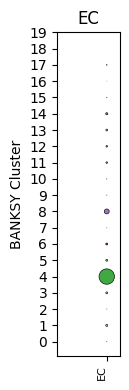

In [53]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('EC', fontsize=12)

plt.tight_layout()
plt.savefig("ECbanksy_IU.png")
plt.show()

## DCT

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define & apply your region mapping (if not already in adata)
region_map = {
    "POD": "Glom", "altPOD": "Glom", "PEC": "Glom",
    "PT": "PT",   "altPT": "PT",
    "DTL": "TL",  "altDTL": "TL",
    "ATL": "TL",  "altATL": "TL",
    "TAL": "TAL", "MD": "TAL",  "altTAL": "TAL",
    "DCT": "DCT", "altDCT": "DCT",
    "CNT": "CNT", "altCNT": "CNT",
    "PC": "PC",   "altPC": "PC",
    "IC": "IC",   "altIC": "IC",
    "EC-GC": "Glom","EC": "EC",
    "FIB": "Stromal",  "altFIB": "Stromal", "infFIB": "Stromal",
    "MYOF": "Stromal", "pvFIB": "Stromal",  "MC": "Glom",
    "REN": "Stromal",  "VSMC_P": "Stromal",
    "B": "Immune",  "PL": "Immune",  "T": "Immune",
    "NK": "Immune", "ERY": "Immune", "MAST": "Immune",
    "resMAC": "Immune","moMAC-INF":"Immune","moMAC":"Immune",
    "DC": "Immune", "MON": "Immune",  "N": "Immune",
    "SC_NEU": "SC_NEU"
}
adata.obs['Region'] = adata.obs['manual_annotations'].map(region_map)


# 2) Build a tidy DataFrame
df = adata.obs[[
    'banksy_clusters',
    'manual_annotations',
    'Region'
]].copy()
df.columns = ['Cluster','Annotation','Region']

# 3) SUBSET to Glom only
df_glom = df[df['Region']=='DCT'].copy()

# 4) Drop any unused categorical levels so only PEC, POD, altPOD remain
df_glom['Annotation'] = df_glom['Annotation'].astype('category')
df_glom['Annotation'] = df_glom['Annotation'].cat.remove_unused_categories()

# 5) Compute counts & within‐Glom proportions
counts = (
    df_glom
      .groupby(['Annotation','Cluster'])
      .size()
      .reset_index(name='Count')
)
counts['Proportion'] = (
    counts
      .groupby('Annotation')['Count']
      .transform(lambda x: x / x.sum())
)

# 6) Prepare plotting coordinates
#   x: only the Glom annotations
x_labels = list(counts['Annotation'].cat.categories)  # ['PEC','POD','altPOD']
x_map    = {lab:i for i,lab in enumerate(x_labels)}
counts['x'] = counts['Annotation'].map(x_map)

#   y: all BANKSY clusters 0–14 (even if some have zero points)
cluster_order = list(range(0,15))
counts['y'] = counts['Cluster'].astype(int)

#   bubble size & color
counts['size'] = counts['Proportion'] * 150
palette = sns.color_palette('tab20', n_colors=len(cluster_order))
color_map = {c: palette[c] for c in cluster_order}
counts['color'] = counts['Cluster'].map(color_map)

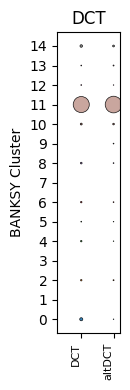

In [109]:
fig, ax = plt.subplots(figsize=(1.4, 4))   # make it tall+narrow

ax.scatter(
    counts['x'], counts['y'],
    s=counts['size'],
    c=counts['color'],
    edgecolor='k',
    linewidth=0.5,
    alpha=0.9
)

# 8) Only PEC/POD/altPOD on x-axis
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# 9) All clusters on y-axis
ax.set_yticks(cluster_order)
ax.set_ylabel('BANKSY Cluster', fontsize=10)

# 10) Remove extra padding so labels hug their positions
ax.set_xlim(-0.75, len(x_labels) - 1 + 0.2)
ax.margins(x=0)

# **this** is the magic line to keep your labels from getting clipped:
fig.subplots_adjust(bottom=0.30) 
# 11) Optionally also set very tight x-limits
#ax.set_xlim(-0.1, len(x_labels)-1 + 0.1)
ax.set_title('DCT', fontsize=12)

plt.tight_layout()
plt.savefig("DCTbanksy_new.png")
plt.show()